# Notebook 1 - Request WCS Elevation Data from Geobasis NRW - Muenster Basin

[GemGIS](https://github.com/cgre-aachen/gemgis) is a package for geographic information processing for geomodeling. In particular, data is prepared for direct use in [GemPy](https://github.com/cgre-aachen/gempy) via a GemPy Data Class. The package provides functions to process spatial data such as vector data (shape files, geojson files, geopackages), raster data (tiff-files), data retrieved from online services (WMS, WCS, WFS) or KML/XML files. 

At a later stage, functionality will be added to interactively add interfaces and orientations for a model, chosing the extent, defining custom sections and more. In addition, functionality will be provided to export data from GemPy into Geoinformation Systems (=GIS) such as QGIS or ArcGIS and Google Earth. 

# Overview

This notebook presents methods to **automatically download tif-tiles of a 1 m Digital Elevation Model (DEM)** for the State of Northrhine Westfalia, Germany, in particular from the Muenster Basin. Alternatively, the single tiles can be downloaded at https://www.tim-online.nrw.de/tim-online2/ or at https://www.opengeodata.nrw.de/produkte/geobasis/hm/dgm1_xyz/ as single tiles or XYZ files for single communes. In addition, functionality is provided to **merge the tiles to a mosaic and to reduce the resolution of the output raster**. Standard `GemGIS` raster methods can be used to save the raster to disk. 

- [What is a Web Coverage Service?](#WCS)
- [Downloading and Installing GemGIS](#gemgis)
- [Structure of GemGIS](#structure)
- [Importing Libraries](#import)
- [Version Reports](#vreport)

<a id='WCS'></a>
## What is a Web Coverage Service (WCS)?

The Web Coverage Service (WCS) is a standard issued by the Open Geospatial Consortium (OGC). It is designed to simplify remote access to coverages, commonly known as raster maps in GIS. WCS functions over the HTTP protocol, setting out how to obtain data and meta-data using the requests available in that protocol. In practice it allows raster maps to be obtained from a web browser or from any other programme that uses the protocol.

Source: https://www.isric.org/web-coverage-services-wcs


<a id='gemgis'></a>
## Downloading and installing GemGIS

`GemGIS` is under constant development and the latest available version can be downloaded at https://github.com/cgre-aachen/gemgis. A pip version can be found at https://pypi.org/project/gemgis/. A dedicated documentation page will follow.

<a id='structure'></a>
## Structure of GemGIS

The core of `GemGIS` is made of the `GemPyData` class (`gemgis.py`). Its attributes can directly be utilized by `GemPy` making it easier for users to load data. Methods of the `GemPyData` class allow users to directly set these attributes. Multiple other files contain functions to manipulate vector data, raster data, etc.:

* `gemgis.py` - core file containing the `GemPyData` class
* `vector.py` - file containing functions to manipulate vector data
* `raster.py` - file containing functions to manipulate raster data
* `utils.py` - file containing utility functions frequently used for the manipulation of vector/raster data
* `wms.py` - file containing methods to load online services as vector and raster data
* `visualization.py` - file containing functions to simplify plotting of spatial data
* `postprocessing.py` - file containing functions to postprocess GemPy geo_model data


If you have any problems using GemGIS, find a bug or have an idea for a new feature, open an issue at https://github.com/cgre-aachen/gemgis/issues. 

<a id='import'></a>
# Importing Libraries

Apart from creating a GemPyData class later in the tutorial, GemGIS is working with pure GeoDataFrames, Rasterio files and NumPy arrays to provide the user with easy data handling. ***Currently, geopandas version 0.8 is the latest stable version that is supported by GemGIS***. A general introduction to working with rasters and Rasterio objects in GemGIS is provided in the next notebook.

The first step is loading `GemGIS` and the auxiliary libraries `geopandas` and `rasterio` apart from `NumPy` and `Matplotlib`. `GemGIS` will also load `GemPy` the background. If the installation of `GemPy`was not successful, `GemGIS` cannot be used. 

In [31]:
import sys
import os
sys.path.append('../../../gemgis')
import gemgis as gg
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
print(gg)

<module 'gemgis' from '../../../gemgis\\gemgis\\__init__.py'>


<a id='vreport'></a>
# Version Reports
Reporting your Python environment's package versions and hardware resources by Scooby - https://github.com/banesullivan/scooby. This overview shows the packages and their versions used to run this notebook. Upgrading or downgrading to older or newer versions may break the notebook.

In [2]:
gg.Report()

--------------------------------------------------------------------------------
  Date: Mon Aug 31 12:28:15 2020 Mitteleuropäische Sommerzeit

                OS : Windows
            CPU(s) : 8
           Machine : AMD64
      Architecture : 64bit
               RAM : 7.9 GB
       Environment : Jupyter

  Python 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]

              json : 2.0.9
             numpy : 1.19.1
            scooby : 0.5.6
            owslib : 0.19.2
            pandas : 1.0.5
           shapely : 1.7.0
           pyvista : 0.25.3
          rasterio : 1.1.0
         geopandas : 0.6.1
          requests : 2.24.0
             scipy : 1.5.2
           skimage : 0.16.2
        matplotlib : 3.3.1

  Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------

# Request Elevation Data from a WCS Server for the Aachen Area

As a WMS Server only provides image data as shown in [Tutorial 3](https://github.com/cgre-aachen/gemgis/blob/master/notebooks/03_GemGIS_Working_with_WMS_Services.ipynb), data must be downloaded from a Web Coverage Service (WCS). For this notebook, we will demonstrate how to download sample files for the Aachen Area to illustrate the functionality. 

## Loading WMS Service for Background Imagery

The WMS Service used in Tutorial 3 will also be used here for Background Imagery. 

### Load WMS Layer and Map

In [2]:
wms = gg.wms.load('https://ows.terrestris.de/osm/service?')

In [20]:
wms_map = gg.wms.load_as_array('https://ows.terrestris.de/osm/service?',
                             'OSM-WMS', 'default', 'EPSG:25832', [300000, 550000,5650000,5850000], [3000, 2000], 'image/png')

### Plot WMS Data

Text(405000, 5758000, 'Münster')

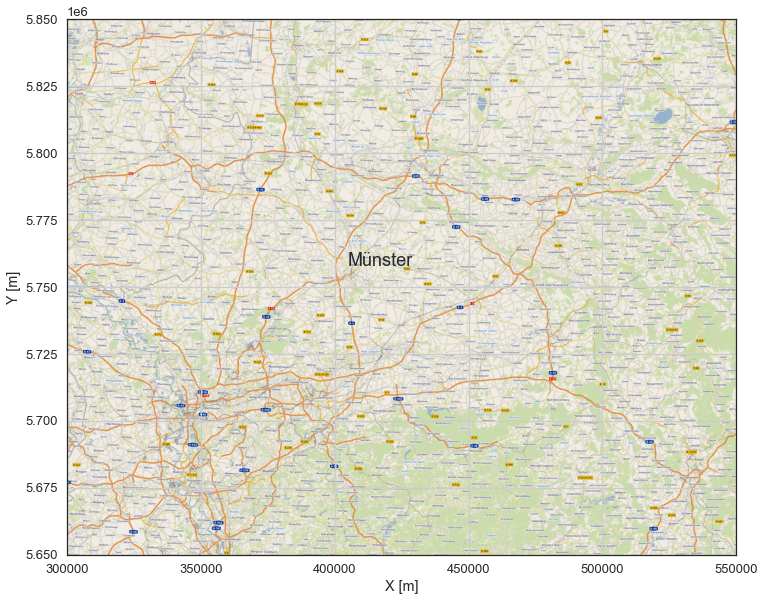

In [22]:
plt.figure(figsize = (12,12))
plt.imshow(wms_map, extent= [300000, 550000,5650000,5850000])
plt.grid()
plt.ylabel('Y [m]')
plt.xlabel('X [m]')
plt.text(405000,5758000, 'Münster', size = 18)

## Load WCS Layer

The WCS Server is being accessed via OWSLib. The attributes `url` and `version` are needed for the following request.

In [16]:
wcs_url = 'https://www.wcs.nrw.de/geobasis/wcs_nw_dgm'
wcs = gg.misc.load_wcs(url=wcs_url)
print(type(wcs))
wcs

<class 'owslib.coverage.wcs201.WebCoverageService_2_0_1'>


In [17]:
wcs.url

'https://www.wcs.nrw.de/geobasis/wcs_nw_dgm'

In [18]:
wcs.version

'2.0.1'

## Creating and Executing WCS Request

The WCS needs to be created by providing min and max values for X and Y locations. Here, a for loop is created to automatically download four tiles with an extent of 2 by 2 km each. Due to their size, they will be saved outside the repository. 

In [36]:
xmin = 360000
xmax = 500000
ymin = 5700000
ymax = 5800000
size = 2000

x = xmax-xmin
print('Extent X: ', x, ' m')
y = ymax-ymin
print('Extent Y: ', y, ' m')

print('Number of tiles in X directions: ', int(x/size))
print('Number of tiles in Y directions: ', int(y/size))

for i in tqdm(range(int(x/size))):
    for j in range(int(y/size)):
        if not os.path.exists('../../../tile_%d_%d_%d_%d.tif' % (xmin+i*size, xmin+(i+1)*size,ymin+j*size, ymin+(j+1)*size)):
            url = gg.misc.create_request(wcs.url, wcs.version, 'nw_dgm', 'image/tiff',[xmin+i*size, xmin+(i+1)*size,ymin+j*size, ymin+(j+1)*size], 'test')
            gg.misc.execute_request(url, '../../../tile_%d_%d_%d_%d.tif' % (xmin+i*size, xmin+(i+1)*size,ymin+j*size, ymin+(j+1)*size))
        else:
            pass

  0%|                                                                                           | 0/70 [00:00<?, ?it/s]

Extent X:  140000  m
Extent Y:  100000  m
Number of tiles in X directions:  70
Number of tiles in Y directions:  50


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [37:16<00:00, 31.94s/it]


## Create List of File paths

In [37]:
dem_fps = gg.misc.create_filepaths(dirpath = '../../../', search_criteria='tile*.tif')
dem_fps[:4]

['C:/users/alexa/Desktop/Muenster\\tile_360000_362000_5700000_5702000.tif',
 'C:/users/alexa/Desktop/Muenster\\tile_360000_362000_5702000_5704000.tif',
 'C:/users/alexa/Desktop/Muenster\\tile_360000_362000_5704000_5706000.tif',
 'C:/users/alexa/Desktop/Muenster\\tile_360000_362000_5706000_5708000.tif']

## Create List of Tiles

The above created list of file paths is automatically being created when executing the function below. In addition, a list of the loaded tiles is created.

In [38]:
src_files_to_mosaic = gg.misc.create_src_list(dirpath ='../../../', search_criteria='tile*.tif')
src_files_to_mosaic[:4]

[<open DatasetReader name='C:/users/alexa/Desktop/Muenster\tile_360000_362000_5700000_5702000.tif' mode='r'>,
 <open DatasetReader name='C:/users/alexa/Desktop/Muenster\tile_360000_362000_5702000_5704000.tif' mode='r'>,
 <open DatasetReader name='C:/users/alexa/Desktop/Muenster\tile_360000_362000_5704000_5706000.tif' mode='r'>,
 <open DatasetReader name='C:/users/alexa/Desktop/Muenster\tile_360000_362000_5706000_5708000.tif' mode='r'>]

## Merge tiles to mosaic with different resolutions

The single files can now automatically be merged to form a mosaic.

In [39]:
mosaic, out_trans = gg.misc.merge_tiles(src_files_to_mosaic, res=50)

In [40]:
mosaic1, out_trans1 = gg.misc.merge_tiles(src_files_to_mosaic, res=25)

In [41]:
mosaic2, out_trans2 = gg.misc.merge_tiles(src_files_to_mosaic, res=10)

In [42]:
mosaic3, out_trans3 = gg.misc.merge_tiles(src_files_to_mosaic, res=5)

## Save Rasters to disc

In [43]:
gg.raster.save_as_tiff('../../../DEM50.tiff', np.flipud(mosaic), extent=[360000,500000,5700000,5800000], crs='EPSG:25832')

In [44]:
gg.raster.save_as_tiff('../../../DEM25.tiff', np.flipud(mosaic1), extent=[360000,500000,5700000,5800000], crs='EPSG:25832')

In [45]:
gg.raster.save_as_tiff('../../../DEM10.tiff', np.flipud(mosaic2), extent=[360000,500000,5700000,5800000], crs='EPSG:25832')

In [46]:
gg.raster.save_as_tiff('../../../DEM5.tiff', np.flipud(mosaic3), extent=[360000,500000,5700000,5800000], crs='EPSG:25832')

## Plot DEM

The mosaic/DEM can now be plotted using the built-in rasterio functionality or using matplotlib. 

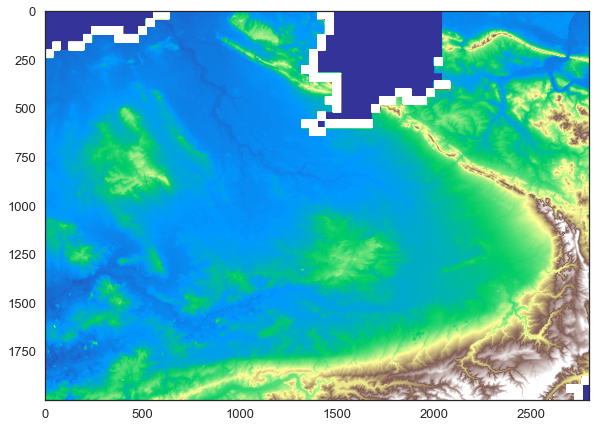

<AxesSubplot:>

In [47]:
from rasterio.plot import show
show(mosaic, cmap='terrain', vmax=400)

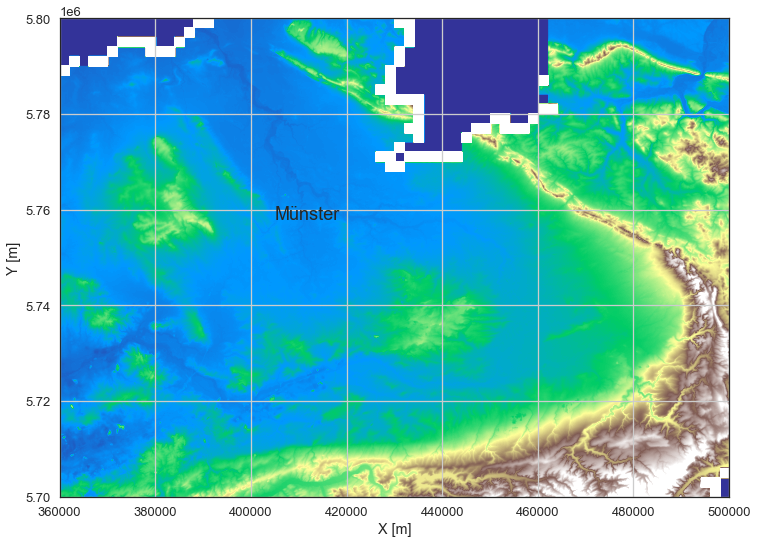

In [48]:
plt.figure(figsize = (12,12))
plt.imshow(wms_map, extent= [300000, 550000,5650000,5850000])
plt.grid()
plt.ylabel('Y [m]')
plt.xlabel('X [m]')
plt.text(405000,5758000, 'Münster', size = 18)
im = plt.imshow(mosaic, cmap='terrain', vmax=400, extent = [360000,500000,5700000,5800000])